In [1]:
from pv_analysis import *
from shadow_matrix_re import *
from visual_utils import *
import pandas as pd
import numpy as np
import tqdm

rad_file_path = 'data/pvdata/Kuopio Savilahti 1.4.2021 - 1.10.2021_rad.csv'
temp_wind_file_path = 'data/pvdata/Kuopio Savilahti 1.4.2021 - 1.10.2021_temp_wind.csv'
clear_minute_file_path = 'data/Clear_sky_minutes_kuopio_RH16.txt'

lidar_file_path = 'output/recovered.laz'
shadow_matrix_folder = 'results/shadow_matrix_results_re_SE_new'
shadow_matrix_name = 'shadow_attenuation_matrix_conecasting_re_SE_n2.csv'

In [31]:
clear_days = find_clear_days(clear_minute_file_path, print_results=True, threshold=0.8)

extra_data_df = pd.read_csv(f'output/extra_data_{clear_days["Date"].iloc[0]}.csv')
extra_data_df['timestamp'] = pd.to_datetime(extra_data_df['timestamp'])
extra_data_df = extra_data_df.set_index('timestamp')
extra_data_df.index.name = 'time'
extra_data_df = extra_data_df[['dni', 'dhi', 'ghi', 'T', 'wind', 'albedo']].round(2)
print(extra_data_df.head())

                           dni   dhi   ghi      T  wind  albedo
time                                                           
2021-07-03 00:00:00+00:00  0.0  0.24 -0.56  16.90  1.40     0.2
2021-07-03 00:05:00+00:00  0.0  0.34 -0.14  16.84  1.40     0.2
2021-07-03 00:10:00+00:00  0.0  0.42  0.22  16.82  1.36     0.2
2021-07-03 00:15:00+00:00  0.0  1.00  1.58  16.62  1.32     0.2
2021-07-03 00:20:00+00:00  0.0  1.48  2.30  16.54  1.42     0.2


In [3]:
shadow_matrix_df = create_shadow_matrix(lidar_file_path=lidar_file_path, voxel_size=2.0, output_dir=shadow_matrix_folder, output_fn=shadow_matrix_name)

Loading LiDAR data from output/recovered.laz...
Data loaded and filtered. 2297097 points remaining.

--- Starting PARALLEL Cone-Casting Simulation ---
Optimized: Skipping elevations > 55°. Processing 20160 directions...
Saved shadow attenuation matrix to results/shadow_matrix_results_re_SE_new/shadow_attenuation_matrix_conecasting_re_SE_n2.csv
Total execution time: 5.65 seconds


Loading shadow matrix...
Calculating seasonal sun paths...


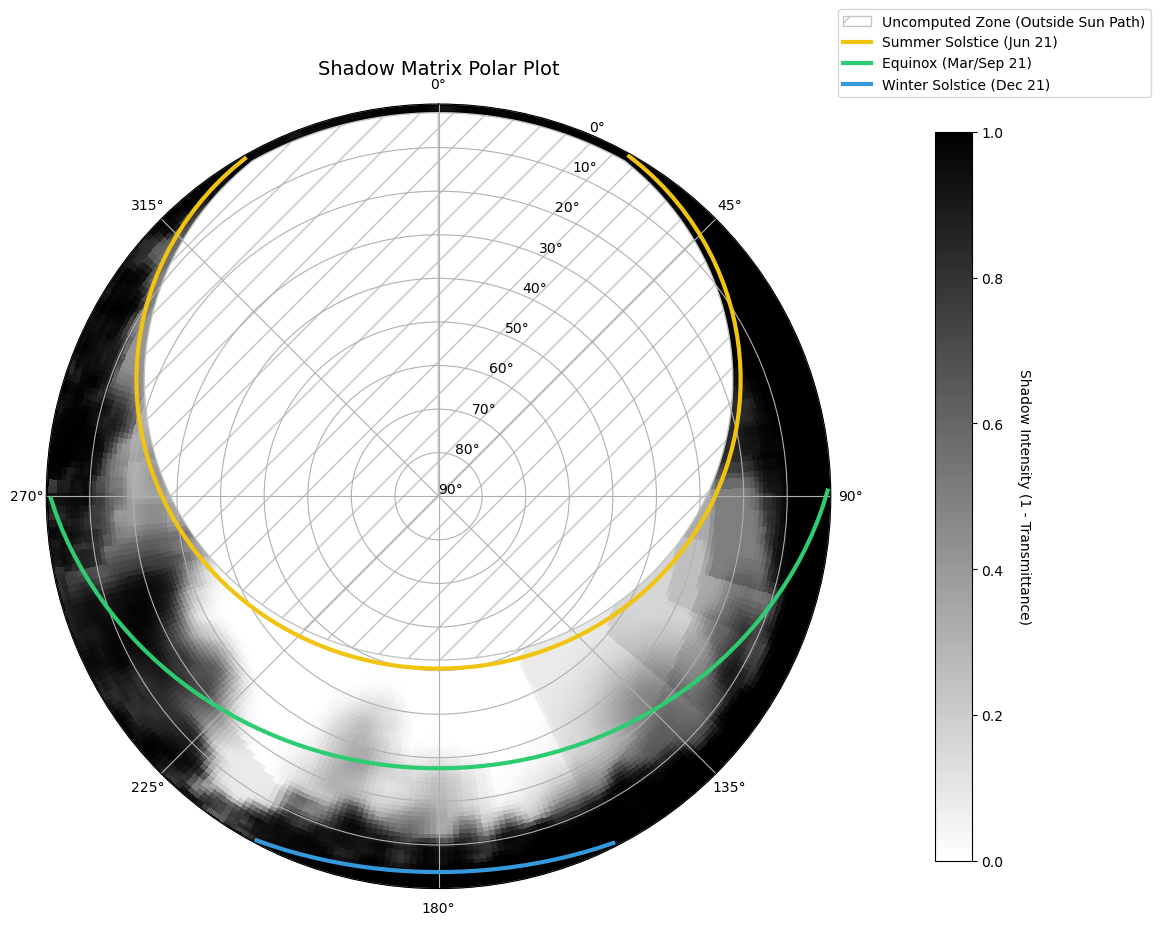

In [4]:
MATRIX_PATH = 'results/shadow_matrix_results_re_SE_new/shadow_attenuation_matrix_conecasting_re_SE_n2.csv'
plot_shadow_matrix_with_sunpaths(MATRIX_PATH)

In [32]:
pv_file_path = 'data/pvdata/pv_21.xlsx'
pv_df = pd.read_excel(pv_file_path, usecols=[0, 2], skiprows=[0, 1], header=None)
pv_df.columns = ['Timestamp', 'Energy_Wh']
pv_df['Timestamp'] = pd.to_datetime(pv_df['Timestamp'], dayfirst=True)
pv_df['Power_W'] = pv_df['Energy_Wh'] * 12

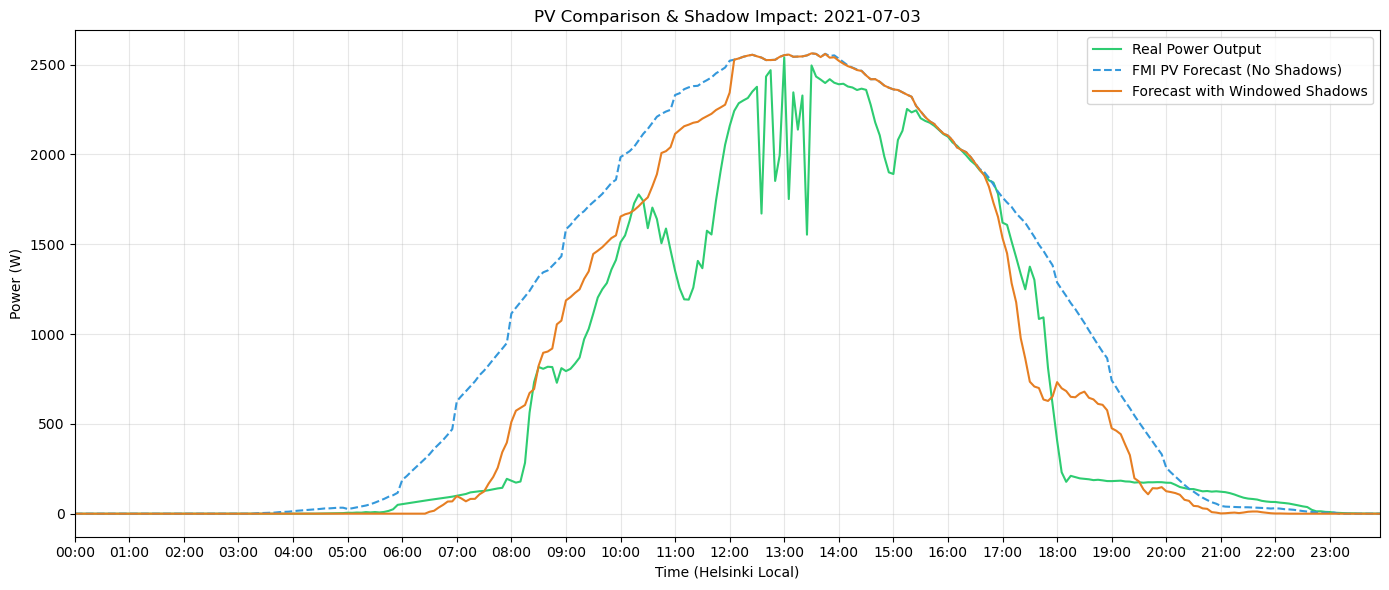

In [33]:
# Note: Using the refined physical (3, 3) anti-aliasing window
day_data, forecast_base, forecast_windowed = pv_analysis(
    target_date=clear_days['Date'].iloc[0], 
    shadow_matrix_df=shadow_matrix_df, 
    excel_df=pv_df, 
    df_extra=extra_data_df, 
    window_size=(2, 2),
    system_efficiency=0.95,
    plot=True
)

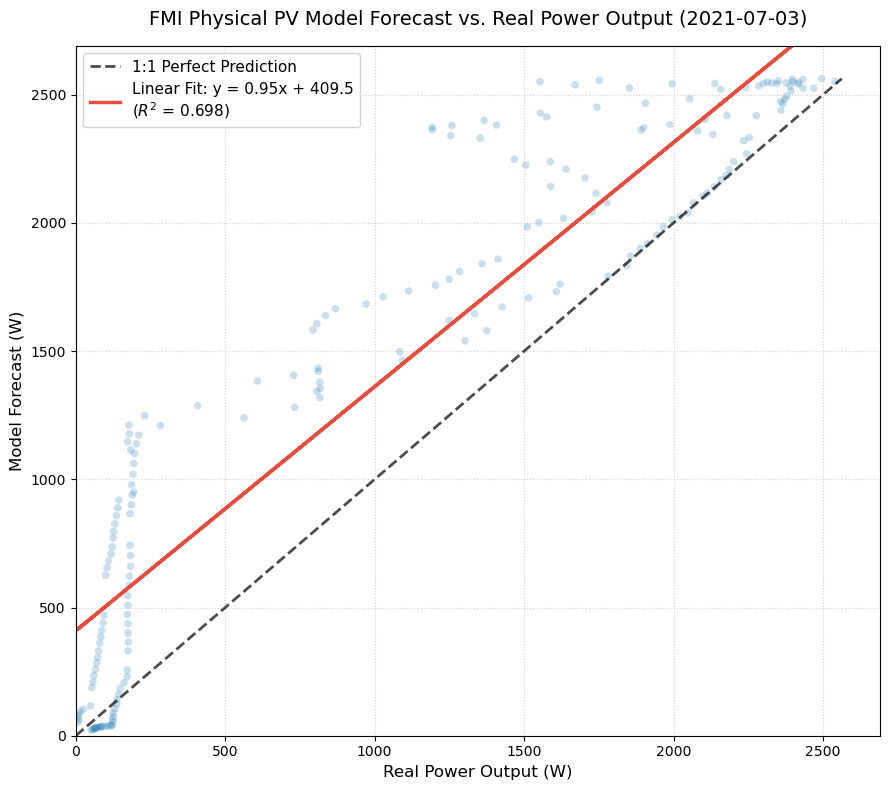

In [35]:
# def plot_publication_scatter(all_real, all_pred):
"""
Generates an academic-grade scatter plot of Real vs. Predicted Power.
"""
real_arr = np.array(day_data['Power_W'].values)
pred_arr = np.array(forecast_base['output'].values)

# Filter out nighttime/zero-value data to prevent artificial R^2 inflation
mask = (real_arr > 50) | (pred_arr > 50)
real_filtered = real_arr[mask]
pred_filtered = pred_arr[mask]

r2 = r2_score(real_filtered, pred_filtered)

# Setup the plot
plt.figure(figsize=(9, 8))

# The Scatter Data
plt.scatter(real_filtered, pred_filtered, alpha=0.25, color='#2980b9', edgecolors='none', s=30)

# The 1:1 Perfect Alignment Line
max_val = max(real_filtered.max(), pred_filtered.max())
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.7, label='1:1 Perfect Prediction', lw=2)

# The Linear Regression Trendline
z = np.polyfit(real_filtered, pred_filtered, 1)
p = np.poly1d(z)

# Determine trendline equation string
sign = "+" if z[1] >= 0 else "-"
eq_str = f"y = {z[0]:.2f}x {sign} {abs(z[1]):.1f}"

plt.plot(real_filtered, p(real_filtered), '#e74c3c', lw=2.5, 
            label=f'Linear Fit: {eq_str}\n($R^2$ = {r2:.3f})')

# Formatting
plt.title(f'FMI Physical PV Model Forecast vs. Real Power Output ({clear_days["Date"].iloc[0]})', fontsize=14, pad=15)
plt.xlabel('Real Power Output (W)', fontsize=12)
plt.ylabel('Model Forecast (W)', fontsize=12)
plt.xlim(0, max_val * 1.05)
plt.ylim(0, max_val * 1.05)

# Move legend to the upper left to avoid covering high-power data points
plt.legend(loc='upper left', fontsize=11, framealpha=0.9)
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

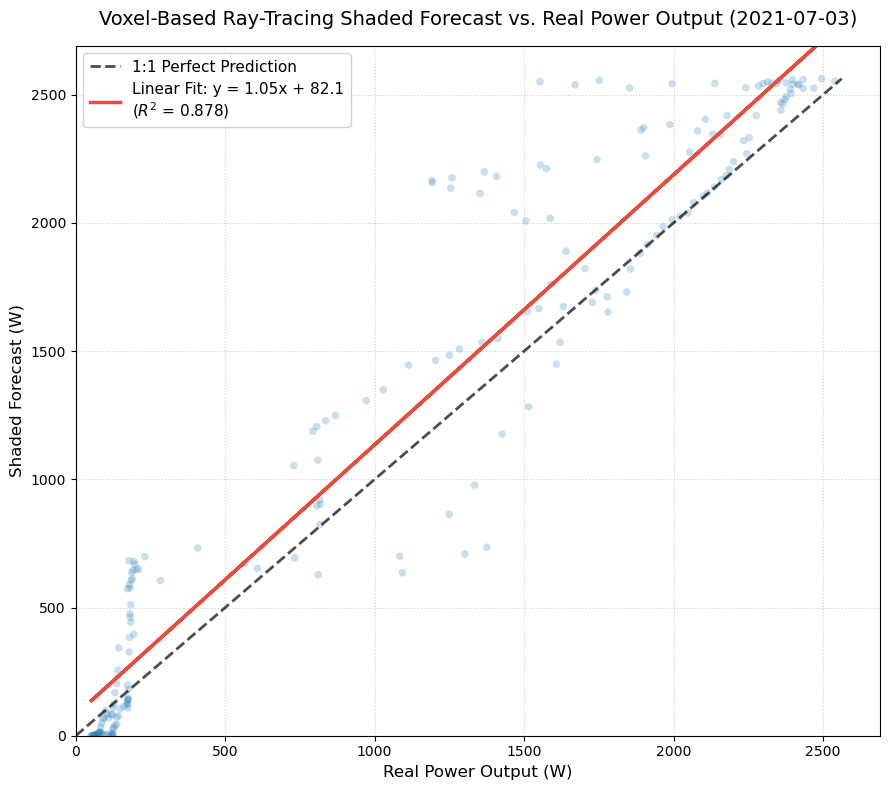

In [36]:
# def plot_publication_scatter(all_real, all_pred):
"""
Generates an academic-grade scatter plot of Real vs. Predicted Power.
"""
real_arr = np.array(day_data['Power_W'].values)
pred_arr = np.array(forecast_windowed['output_shaded'].values)

# Filter out nighttime/zero-value data to prevent artificial R^2 inflation
mask = (real_arr > 50) | (pred_arr > 50)
real_filtered = real_arr[mask]
pred_filtered = pred_arr[mask]

r2 = r2_score(real_filtered, pred_filtered)

# Setup the plot
plt.figure(figsize=(9, 8))

# The Scatter Data
plt.scatter(real_filtered, pred_filtered, alpha=0.25, color='#2980b9', edgecolors='none', s=30)

# The 1:1 Perfect Alignment Line
max_val = max(real_filtered.max(), pred_filtered.max())
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.7, label='1:1 Perfect Prediction', lw=2)

# The Linear Regression Trendline
z = np.polyfit(real_filtered, pred_filtered, 1)
p = np.poly1d(z)

# Determine trendline equation string
sign = "+" if z[1] >= 0 else "-"
eq_str = f"y = {z[0]:.2f}x {sign} {abs(z[1]):.1f}"

plt.plot(real_filtered, p(real_filtered), '#e74c3c', lw=2.5, 
            label=f'Linear Fit: {eq_str}\n($R^2$ = {r2:.3f})')

# Formatting
plt.title(f'Voxel-Based Ray-Tracing Shaded Forecast vs. Real Power Output ({clear_days["Date"].iloc[0]})', fontsize=14, pad=15)
plt.xlabel('Real Power Output (W)', fontsize=12)
plt.ylabel('Shaded Forecast (W)', fontsize=12)
plt.xlim(0, max_val * 1.05)
plt.ylim(0, max_val * 1.05)

# Move legend to the upper left to avoid covering high-power data points
plt.legend(loc='upper left', fontsize=11, framealpha=0.9)
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

In [37]:
def print_performance_metrics(performance_metrics):
    print("\n" + "="*50)
    print(" PV FORECAST PERFORMANCE METRICS (CLEAR DAYS) ")
    print("="*50)
    
    # Extract arrays
    rmse_b, rmse_s = np.mean(performance_metrics['RMSE_Base']), np.mean(performance_metrics['RMSE_Shaded'])
    mae_b, mae_s = np.mean(performance_metrics['MAE_Base']), np.mean(performance_metrics['MAE_Shaded'])
    mbe_b, mbe_s = np.mean(performance_metrics['MBE_Base']), np.mean(performance_metrics['MBE_Shaded'])
    
    print("\n--- ERROR METRICS (Watts) ---")
    print(f"RMSE (Baseline) : {rmse_b:.2f} W")
    print(f"RMSE (Shaded)   : {rmse_s:.2f} W  --> {((rmse_b - rmse_s)/rmse_b)*100:.1f}% Improvement")
    
    print(f"\nMAE  (Baseline) : {mae_b:.2f} W")
    print(f"MAE  (Shaded)   : {mae_s:.2f} W  --> {((mae_b - mae_s)/mae_b)*100:.1f}% Improvement")
    
    print(f"\nMBE  (Baseline) : {mbe_b:.2f} W")
    print(f"MBE  (Shaded)   : {mbe_s:.2f} W  --> Closer to 0 is better")

    print("\n--- ENERGY YIELD METRICS (kWh) ---")
    t_real = performance_metrics['Real_Wh'] / 1000
    t_base = performance_metrics['Base_Wh'] / 1000
    t_shaded = performance_metrics['Shaded_Wh'] / 1000
    
    print(f"Total Real Energy Yield     : {t_real:.2f} kWh")
    print(f"Total Baseline Forecast     : {t_base:.2f} kWh (Error: {((t_base - t_real)/t_real)*100:+.1f}%)")
    print(f"Total Shaded Forecast       : {t_shaded:.2f} kWh (Error: {((t_shaded - t_real)/t_real)*100:+.1f}%)")
    print("="*50)

In [38]:
performance_metrics = {
        'RMSE_Base': [], 'RMSE_Shaded': [],
        'MAE_Base': [], 'MAE_Shaded': [],
        'MBE_Base': [], 'MBE_Shaded': [],
        'Real_Wh': 0.0, 'Base_Wh': 0.0, 'Shaded_Wh': 0.0
    }

In [39]:
for day in tqdm.tqdm(clear_days['Date'], desc="Processing clear days"):
    extra_data_df = pd.read_csv(f'output/extra_data_{day}.csv')
    extra_data_df['timestamp'] = pd.to_datetime(extra_data_df['timestamp'])
    extra_data_df = extra_data_df.set_index('timestamp')
    extra_data_df.index.name = 'time'
    extra_data_df = extra_data_df[['dni', 'dhi', 'ghi', 'T', 'wind', 'albedo']]
    extra_data_df = extra_data_df.round(2)
    day_data, forecast_base, forecast_windowed = pv_analysis(
        target_date=day, 
        shadow_matrix_df=shadow_matrix_df, 
        excel_df=pv_df, 
        df_extra=extra_data_df, 
        window_size=(2, 2),
        system_efficiency=0.95,
        plot=False
    )
    metrics = compute_metrics(day_data, forecast_base, forecast_windowed)
    performance_metrics['RMSE_Base'].append(metrics['RMSE_Base'])
    performance_metrics['RMSE_Shaded'].append(metrics['RMSE_Shaded'])
    performance_metrics['MAE_Base'].append(metrics['MAE_Base'])
    performance_metrics['MAE_Shaded'].append(metrics['MAE_Shaded'])
    performance_metrics['MBE_Base'].append(metrics['MBE_Base'])
    performance_metrics['MBE_Shaded'].append(metrics['MBE_Shaded'])
    performance_metrics['Real_Wh'] += metrics['Real_Wh']
    performance_metrics['Base_Wh'] += metrics['Base_Wh']
    performance_metrics['Shaded_Wh'] += metrics['Shaded_Wh']

print_performance_metrics(performance_metrics)


Processing clear days: 100%|██████████| 20/20 [00:00<00:00, 35.55it/s]


 PV FORECAST PERFORMANCE METRICS (CLEAR DAYS) 

--- ERROR METRICS (Watts) ---
RMSE (Baseline) : 547.56 W
RMSE (Shaded)   : 389.97 W  --> 28.8% Improvement

MAE  (Baseline) : 355.85 W
MAE  (Shaded)   : 227.96 W  --> 35.9% Improvement

MBE  (Baseline) : 338.59 W
MBE  (Shaded)   : 161.87 W  --> Closer to 0 is better

--- ENERGY YIELD METRICS (kWh) ---
Total Real Energy Yield     : 324.76 kWh
Total Baseline Forecast     : 487.28 kWh (Error: +50.0%)
Total Shaded Forecast       : 402.46 kWh (Error: +23.9%)


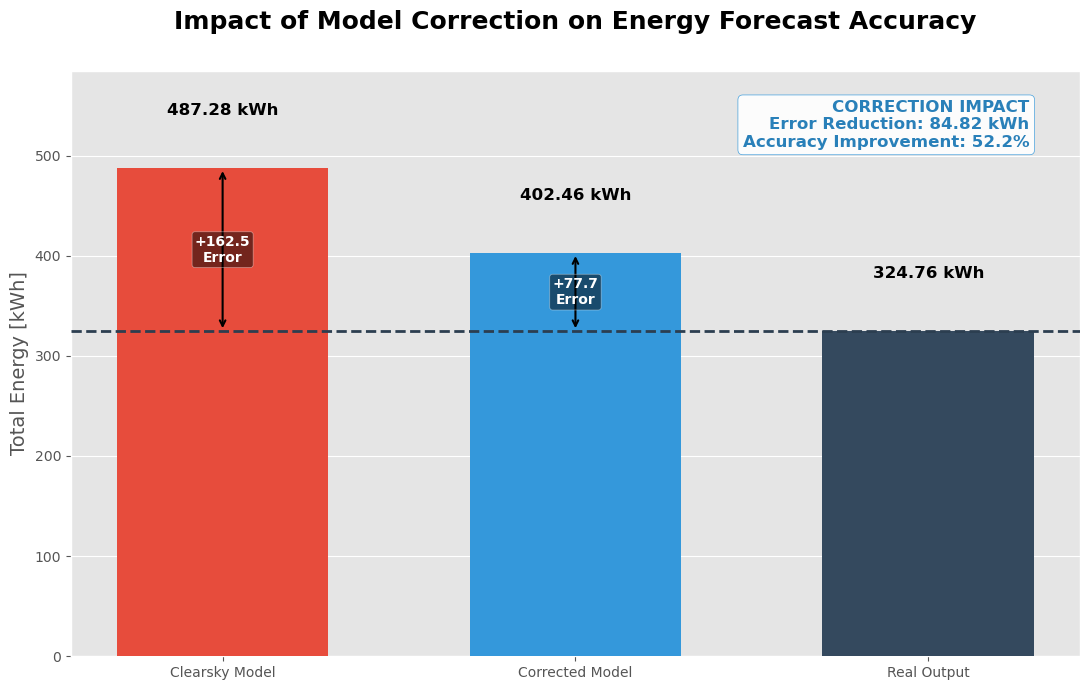

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Data Setup ---
labels = ['Clearsky Model', 'Corrected Model', 'Real Output']
values = [487.28, 402.46, 324.76]
target = values[2] # Real Measured Output

# Calculate the error (Overestimation)
errors = [v - target for v in values]
improvement_pct = ((errors[0] - errors[1]) / errors[0]) * 100

# --- 2. Plot Configuration ---
plt.style.use('ggplot') # Using a clean, professional base style
fig, ax = plt.subplots(figsize=(11, 7))

# Colors: Muted Red (Error), Vibrant Blue (Corrected), Dark Grey (Reality)
colors = ['#e74c3c', '#3498db', '#34495e']

# Create Bars
bars = ax.bar(labels, values, color=colors, width=0.6, zorder=3)

# --- 3. The "Better" Elements ---

# A. Add a Target Line for Real Output
ax.axhline(y=target, color='#2c3e50', linestyle='--', linewidth=2, label='Target (Real)', zorder=4)

# B. Annotate the "Gap" (Error) visually
for i, bar in enumerate(bars[:2]): # Only for the two models
    height = bar.get_height()
    error_val = values[i] - target
    ax.annotate('', xy=(bar.get_x() + bar.get_width()/2, target), 
                xytext=(bar.get_x() + bar.get_width()/2, height),
                arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
    ax.text(bar.get_x() + bar.get_width()/2, target + (error_val/2), 
            f'+{error_val:.1f}\nError', ha='center', va='center', 
            fontsize=10, fontweight='bold', color='white',
            bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

# C. Value Labels on top
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 50, f'{yval:,.2f} kWh', 
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# --- 4. Styling and Text ---
ax.set_title('Impact of Model Correction on Energy Forecast Accuracy', fontsize=18, pad=30, fontweight='bold')
ax.set_ylabel('Total Energy [kWh]', fontsize=14)
ax.set_ylim(0, max(values) * 1.2)
ax.grid(axis='x') # Hide vertical grid for cleaner look

# Summary Insight Box
info_text = (
    f"CORRECTION IMPACT\n"
    f"Error Reduction: {errors[0]-errors[1]:.2f} kWh\n"
    f"Accuracy Improvement: {improvement_pct:.1f}%"
)
ax.text(0.95, 0.95, info_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right', 
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='#3498db', alpha=0.9),
        fontweight='bold', color='#2980b9')

plt.tight_layout()
plt.show()

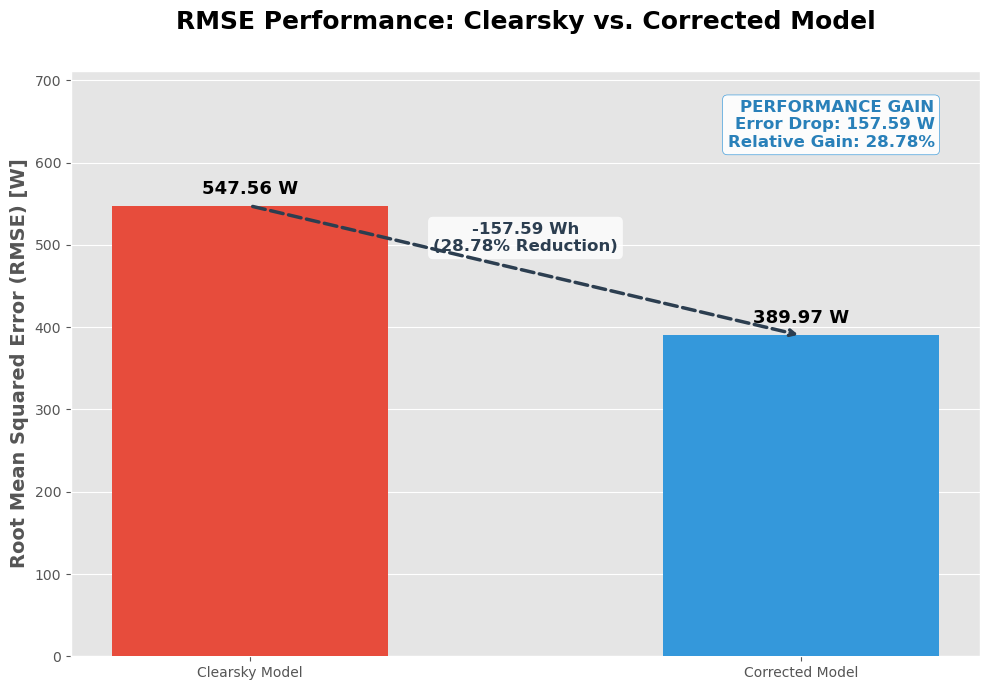

In [44]:
import matplotlib.pyplot as plt

# --- 1. Data Setup ---
labels = ['Clearsky Model', 'Corrected Model']
rmse_values = [547.56, 389.97]
improvement = rmse_values[0] - rmse_values[1]
improvement_pct = (improvement / rmse_values[0]) * 100

# --- 2. Plot Configuration ---
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7))

# Colors: Red for higher error, Blue for the Corrected Model
colors = ['#e74c3c', '#3498db']

# Create Bars
bars = ax.bar(labels, rmse_values, color=colors, width=0.5, zorder=3)

# --- 3. Visual Stress on Improvement ---

# A. Adding an arrow to show the "Drop" in Error
ax.annotate('', xy=(1, rmse_values[1]), 
            xytext=(0, rmse_values[0]),
            arrowprops=dict(arrowstyle='->', color='#2c3e50', lw=2.5, linestyle='--'),
            zorder=4)

# B. Label the reduction directly between the bars
midpoint_x = 0.5
midpoint_y = (rmse_values[0] + rmse_values[1]) / 2
ax.text(midpoint_x, midpoint_y + 20, f'-{improvement:.2f} Wh\n({improvement_pct:.2f}% Reduction)', 
        ha='center', va='bottom', fontsize=12, fontweight='bold', color='#2c3e50',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3'))

# C. Value Labels on top of bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 10, f'{yval:.2f} W', 
            ha='center', va='bottom', fontsize=13, fontweight='bold')

# --- 4. Styling and Text ---
ax.set_title('RMSE Performance: Clearsky vs. Corrected Model', fontsize=18, pad=30, fontweight='bold')
ax.set_ylabel('Root Mean Squared Error (RMSE) [W]', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(rmse_values) * 1.3)
ax.grid(axis='x')

# Summary Insight Box
info_text = (
    f"PERFORMANCE GAIN\n"
    f"Error Drop: {improvement:.2f} W\n"
    f"Relative Gain: {improvement_pct:.2f}%"
)
ax.text(0.95, 0.95, info_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right', 
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='#3498db', alpha=0.9),
        fontweight='bold', color='#2980b9')

plt.tight_layout()
plt.savefig('rmse_comparison_plot.png')
plt.show()

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def generate_publication_array_diagram():
    # 1. Array Configuration
    panel_w = 1.0  # meters
    panel_h = 1.6  # meters
    row_configuration = [5, 4, 3] # Top to bottom
    
    total_h = len(row_configuration) * panel_h
    max_width = max(row_configuration) * panel_w
    
    # 2. Setup Figure
    fig, ax = plt.subplots(figsize=(8, 8))
    
    y_cursor = total_h / 2
    
    # 3. Draw the Panels (Left-Aligned)
    for r_idx, num_panels in enumerate(row_configuration):
        y_cursor -= panel_h
        
        # LEFT-ALIGNED: Start X is always the same for every row
        start_x = -max_width / 2
        
        for p_idx in range(num_panels):
            x = start_x + p_idx * panel_w
            
            # Draw individual panel
            rect = patches.Rectangle((x, y_cursor), panel_w, panel_h, 
                                     linewidth=1.5, edgecolor='#2c3e50', 
                                     facecolor='#3498db', alpha=0.8)
            ax.add_patch(rect)
            
            # Label panel center
            ax.text(x + panel_w/2, y_cursor + panel_h/2, f'R{r_idx+1}-P{p_idx+1}', 
                    color='white', weight='bold', fontsize=9, ha='center', va='center')

    # 4. Add Dimension Annotations
    ax.annotate('', xy=(-max_width/2, total_h/2 + 0.2), xytext=(-max_width/2 + max_width, total_h/2 + 0.2),
                arrowprops=dict(arrowstyle='<->', color='#333333'))
    ax.text(0, total_h/2 + 0.35, f'Max Width: {max_width} m', ha='center', fontsize=10)

    # 5. Formatting
    ax.set_xlim(-max_width/2 - 1, max_width/2 + 1)
    ax.set_ylim(-total_h/2 - 1, total_h/2 + 1)
    
    ax.set_aspect('equal')
    ax.set_title("Top-Down Footprint: 5-4-3 PV Array (Left-Aligned)\n(Azimuth: 170° | Tilt: 12°)", 
                 fontsize=14, pad=20)
    ax.set_xlabel("Local X Dimension (meters)", fontsize=12)
    ax.set_ylabel("Local Y Dimension (meters)", fontsize=12)
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # Save as high-res PDF
    plt.savefig('pv_array_left_aligned.pdf', format='pdf', bbox_inches='tight', dpi=300)
    print("Saved publication diagram to 'pv_array_left_aligned.pdf'")
    
    plt.show()


Saved publication diagram to 'pv_array_left_aligned.pdf'


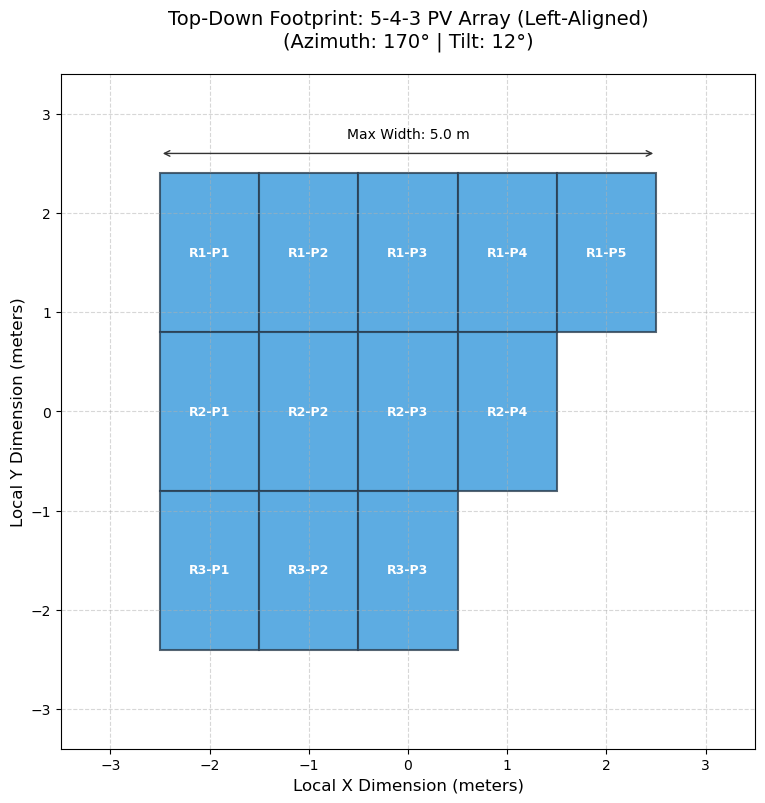

In [24]:
generate_publication_array_diagram()

In [40]:
import numpy as np
import laspy
import matplotlib.pyplot as plt

def calculate_api_grid(file_path, grid_size=2.0):
    """
    Calculates the All-echo Penetration Index (API) for a LiDAR point cloud.
    API is defined as the ratio of ground returns to total returns in a given vertical column.
    
    :param file_path: Path to the .laz or .las file.
    :param grid_size: The XY resolution of the output grid in meters.
    :return: A 2D numpy array of API values, and the spatial extent.
    """
    print(f"Loading LiDAR data from {file_path}...")
    las = laspy.read(file_path)
    
    # Extract coordinates and classifications
    points = np.vstack((las.x, las.y)).T
    classes = np.array(las.classification)

    # Filter for Ground (2) and Vegetation (3, 4, 5)
    valid_mask = np.isin(classes, [2, 3, 4, 5])
    points = points[valid_mask]
    classes = classes[valid_mask]

    # Determine spatial boundaries
    min_x, min_y = np.min(points[:, 0]), np.min(points[:, 1])
    max_x, max_y = np.max(points[:, 0]), np.max(points[:, 1])

    cols = int(np.ceil((max_x - min_x) / grid_size))
    rows = int(np.ceil((max_y - min_y) / grid_size))

    print(f"Creating a {cols}x{rows} spatial grid at {grid_size}m resolution...")

    # Bin points into grid cells
    col_indices = np.clip(np.floor((points[:, 0] - min_x) / grid_size).astype(int), 0, cols - 1)
    row_indices = np.clip(np.floor((points[:, 1] - min_y) / grid_size).astype(int), 0, rows - 1)

    # Convert 2D indices to flat 1D indices for fast counting
    flat_indices = row_indices * cols + col_indices

    # 1. Count Total Returns per cell
    total_counts = np.bincount(flat_indices, minlength=rows*cols)

    # 2. Count Ground Returns per cell (Class 2)
    ground_mask = (classes == 2)
    ground_counts = np.bincount(flat_indices[ground_mask], minlength=rows*cols)

    # 3. Calculate API (Ground / Total)
    api_flat = np.zeros_like(total_counts, dtype=np.float32)
    
    # Only calculate where total_counts > 0 to avoid division by zero
    valid_cells = total_counts > 0
    api_flat[valid_cells] = ground_counts[valid_cells] / total_counts[valid_cells]

    # Reshape back to 2D
    api_grid = api_flat.reshape((rows, cols))
    extent = [min_x, max_x, min_y, max_y]

    print("API calculation complete.")
    return api_grid, extent

def plot_api_map(api_grid, extent):
    """Visualizes the API matrix as a heatmap."""
    plt.figure(figsize=(10, 8))
    # API of 1.0 means clear sky/bare ground. 0.0 means completely dense canopy.
    plt.imshow(api_grid, extent=extent, origin='lower', cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(label='All-echo Penetration Index (API)')
    plt.title('Canopy Gap Fraction (API) Map')
    plt.xlabel('Easting')
    plt.ylabel('Northing')
    plt.tight_layout()
    plt.show()



Loading LiDAR data from output/recovered.laz...
Creating a 250x250 spatial grid at 2.0m resolution...
API calculation complete.


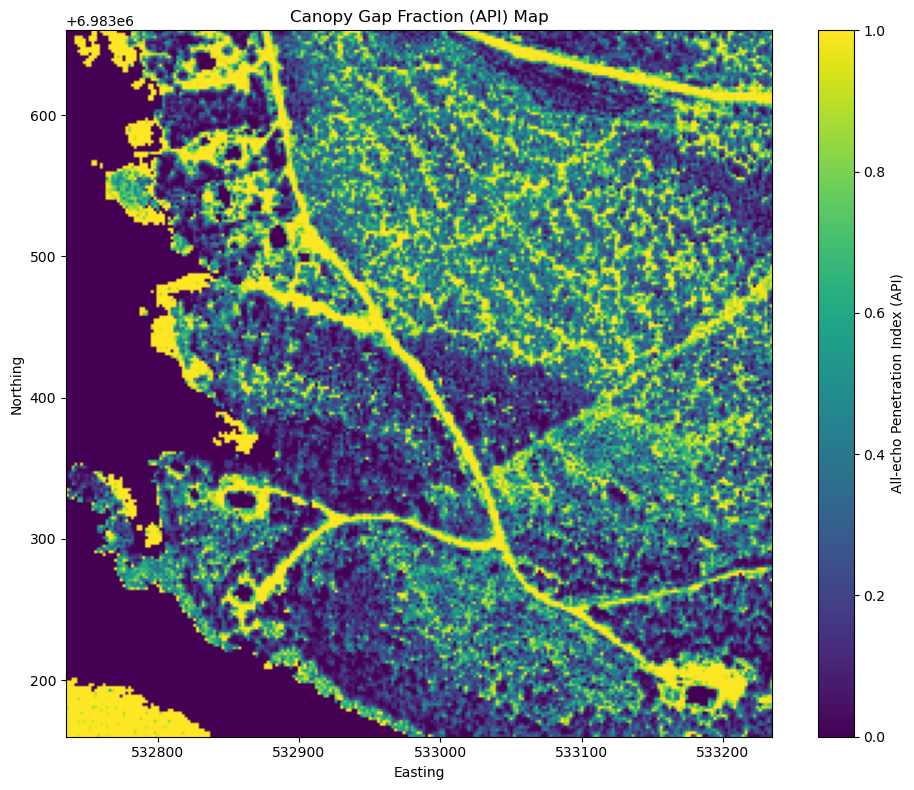

In [42]:
FILE_PATH = 'output/recovered.laz'
    
api_grid, spatial_extent = calculate_api_grid(FILE_PATH, grid_size=2.0)
plot_api_map(api_grid, spatial_extent)